In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from spacy.lang.en.examples import sentences 
import spacy as sp
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet 
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing import text

%matplotlib inline

# import zipfile


# import seaborn as sns
# sns.set()

# #Make sure to pip install monkeylearn first
# from monkeylearn import MonkeyLearn
from textblob import TextBlob
import re

In [4]:
tweets = pd.read_csv('data/TrumpTweetsCleaned.csv')
#09-11-2017 to 02-16-2018
before = pd.to_datetime('2017-09-11')
after = pd.to_datetime('2018-02-16')
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
# new_tweets = tweets[(tweets['created_at']>=before) and (tweets['created_at']<=after)]
tweets.head()

,text,created_at,retweet_count,favorite_count,is_retweet
0,Look at the way Crooked Hillary is handling th...,2016-11-01 10:31:00,21459.0,55584.0,False
1,Wow now leading in @ABC /@washingtonpost Poll ...,2016-11-01 11:55:00,16479.0,39631.0,False
2,Crooked Hillary should not be allowed to run f...,2016-11-01 12:01:00,23747.0,59656.0,False
3,JOIN ME TOMORROW IN FLORIDA!MIAMI‚Ä¢12pmhttps:...,2016-11-01 13:35:00,8773.0,17583.0,False
4,So terrible that Crooked didn't report she got...,2016-11-01 14:14:00,32713.0,80724.0,False


In [37]:
tweets['polarity'] = [TextBlob(tweets['text'].values[i]).polarity for i in range(len(tweets))]
tweets['subjectivity'] = [TextBlob(tweets['text'].values[i]).subjectivity for i in range(len(tweets))]
tweets.head()

,text,created_at,retweet_count,favorite_count,is_retweet,polarity,subjectivity
0,Look at the way Crooked Hillary is handling th...,2016-11-01 10:31:00,21459.0,55584.0,False,-0.2625,0.422917
1,Wow now leading in @ABC /@washingtonpost Poll ...,2016-11-01 11:55:00,16479.0,39631.0,False,0.2000,0.533333
2,Crooked Hillary should not be allowed to run f...,2016-11-01 12:01:00,23747.0,59656.0,False,0.0000,0.100000
3,JOIN ME TOMORROW IN FLORIDA!MIAMI‚Ä¢12pmhttps:...,2016-11-01 13:35:00,8773.0,17583.0,False,0.0000,0.000000
4,So terrible that Crooked didn't report she got...,2016-11-01 14:14:00,32713.0,80724.0,False,-0.5000,0.550000


In [38]:
len(tweets[tweets['polarity']==0])/len(tweets)

0.19706092458414123

In [39]:
processed_features = []

for sentence in range(0, len(tweets['text'].values)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(tweets['text'].values[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [40]:
tweets['test'] = [TextBlob(processed_features[i]).polarity for i in range(len(processed_features))]
len(tweets[tweets['test']==0])/len(tweets)

0.19491784876007756

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


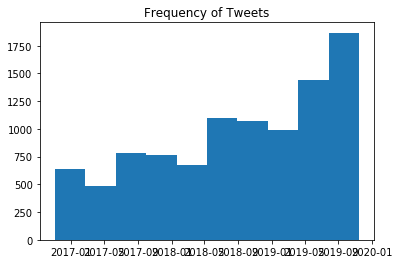

In [41]:
temp = plt.hist(tweets['created_at'])
plt.title('Frequency of Tweets')
plt.show()

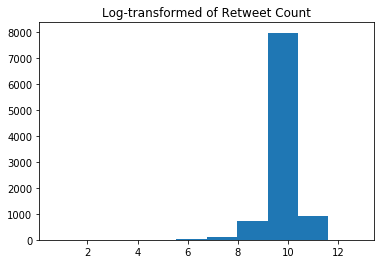

In [42]:
temp2 = plt.hist(np.log(tweets['retweet_count']))
plt.title('Log-transformed of Retweet Count')
plt.show()

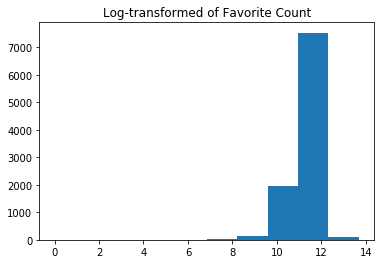

In [44]:
temp3 = plt.hist(np.log(tweets['favorite_count'] + 1))
plt.title('Log-transformed of Favorite Count')
plt.show()

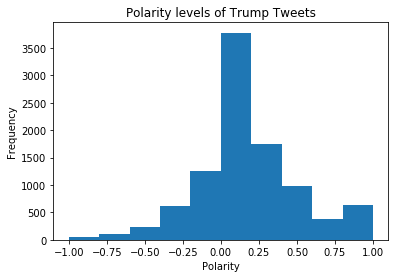

In [43]:
plt.hist(tweets['polarity'])
plt.title('Polarity levels of Trump Tweets')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

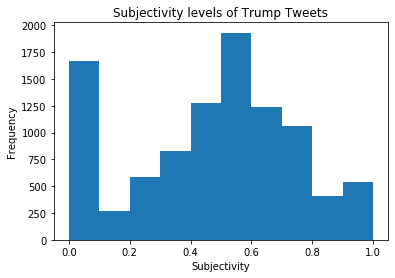

In [45]:
plt.hist(tweets['subjectivity'])
plt.title('Subjectivity levels of Trump Tweets')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.show()

In [12]:
# tweets[(tweets['polarity']==0) & (tweets['subjectivity'] == 0)]

In [46]:
succ = []
for i in range(len(tweets)):
    phrase = tweets['text'].values[i].lower()
    word = 'china'
    if word in phrase:
        succ.append(1)
    else:
        succ.append(0)
tweets['china'] = succ
#tweets[tweets['china']==1]

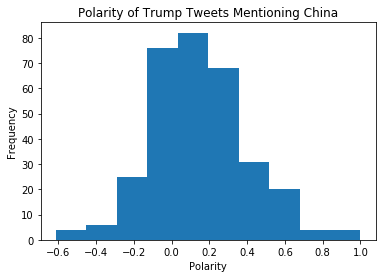

In [47]:
plt.hist(tweets[tweets['china']==1]['polarity'])
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Polarity of Trump Tweets Mentioning China')
plt.show()

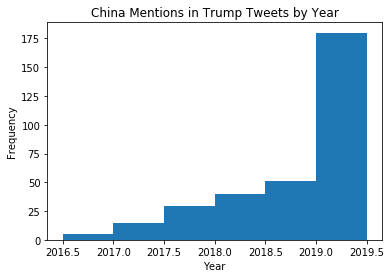

In [48]:
bins = [2016.5, 2017, 2017.5, 2018, 2018.5, 2019, 2019.5]
plt.hist(np.add([r.year for r in tweets[tweets['china']==1]['created_at']], [0.5 if r.week > 26 else 0 for r in tweets[tweets['china']==1]['created_at']]),bins=bins)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('China Mentions in Trump Tweets by Year')
plt.show()

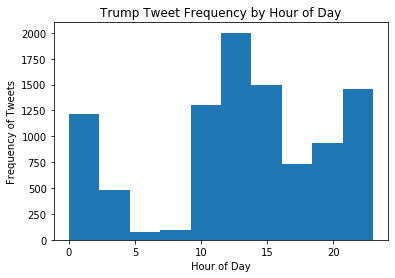

In [49]:
plt.hist([r.hour for r in tweets.created_at])
plt.xlabel('Hour of Day')
plt.ylabel('Frequency of Tweets')
plt.title('Trump Tweet Frequency by Hour of Day')
plt.show()

## Stock Data 

In [50]:
stock = pd.read_csv('data/SP500_intraday.csv')

In [51]:
tweet_dates = tweets['created_at']
tweet_dates.head()

0   2016-11-01 10:31:00
1   2016-11-01 11:55:00
2   2016-11-01 12:01:00
3   2016-11-01 13:35:00
4   2016-11-01 14:14:00
Name: created_at, dtype: datetime64[ns]

In [53]:
stock['Time_pd'] = pd.to_timedelta(stock['Time']+':00')
stock['Date_time'] = pd.to_datetime(pd.to_datetime(stock['Date'])+ pd.to_timedelta(stock['Time_pd']))

In [54]:
latest_time = stock['Date_time'].iloc[-1]
earliest_time = stock['Date_time'][0] 
tweets = tweets[(tweets['created_at'] > earliest_time) & (tweets['created_at'] < latest_time)]
tweets = tweets.reset_index(drop = True)

In [55]:
## Edit the minute after
time_min = 1
time_after = tweets['created_at'] + pd.to_timedelta(time_min, unit = 'm')
time_of = tweets['created_at']
good_time_after = sorted(list(set(stock['Date_time']) & set(time_after)))
x = np.arange(0,len(good_time_after))
tweets_stock_viable = tweets.iloc[np.concatenate([np.where(time_after == good_time_after[x])[0] for x in x])]

time_after2 = tweets_stock_viable['created_at'] + pd.to_timedelta(time_min, unit = 'm')
time_of2 = tweets_stock_viable['created_at']
x = time_of2



bad_var = [stock[stock['Date_time'] == time_of2[i]]['Open'].values
             for i in tweets_stock_viable.index]
bad = np.where(pd.DataFrame(bad_var, index = tweets_stock_viable.index).isna())[0]
tweets_stock_viable = tweets_stock_viable.drop(tweets_stock_viable.index[bad])
stock_df = [stock[stock['Date_time'] == time_after2[i]]['Close'].values - stock[stock['Date_time'] == time_of2[i]]['Open'].values
             for i in x.index]

In [ ]:
# tweets_stock_viable = tweets_stock_viable.drop(tweets_stock_viable.index[bad])
# time_after3 = tweets_stock_viable['created_at'] + pd.to_timedelta(time_min, unit = 'm')
# time_of3 = tweets_stock_viable['created_at']
# x = time_of3
# stock_df = [stock[stock['Date_time'] == time_after3[i]]['Close'].values - stock[stock['Date_time'] == time_of3[i]]['Open'].values
#              for i in x.index]

In [56]:
tweets_stock_viable['stock_dif'] = pd.DataFrame(np.concatenate(stock_df), index= tweets_stock_viable.index)
length = len(tweets_stock_viable)
tweets_stock_viable['stock_up'] = [1 if tweets_stock_viable['stock_dif'][i] > 0 else 0 for i in tweets_stock_viable.index]

In [57]:
# Creating new feature variable - mentions of China in trump tweets
def add_indicator(keyword):
    succ = []
    for i in range(len(tweets_stock_viable)):
        phrase = tweets_stock_viable['text'].values[i].lower()
        word = keyword
        if word in phrase:
            succ.append(1)
        else:
            succ.append(0)
    tweets_stock_viable[keyword] = succ

add_indicator('china')
add_indicator('tariff')
add_indicator('farmer')
add_indicator('trade')
add_indicator('war')



# Final DF

In [ ]:
tweets_stock_viable.head()

In [2]:
tweets_stock_viable.to_csv('data/tweets_stock_viable', index = False)
delta_t = tweets_stock_viable.created_at[1:]-tweets_stock_viable.created_at[0:-1]

NameError: name 'tweets_stock_viable' is not defined

# Baseline Models

In [27]:
tweets_to_split = tweets_stock_viable.drop(columns=['stock_dif','text', 'is_retweet', 'created_at'])
X_train, X_test, y_train, y_test = train_test_split(tweets_to_split.loc[:, tweets_to_split.columns != 'stock_up'], 
                                                         tweets_to_split.stock_up, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = tweets_to_split.stock_up)

In [28]:
#logistic regression=
Logit = LogisticRegression(C = 100000)
baseline_logit = Logit.fit(X_train, y_train)

print('train score:', baseline_logit.score(X_train, y_train))
print('test score:', accuracy_score(baseline_logit.predict(X_test), y_test))

train score: 0.614105504587156
test score: 0.6134453781512605


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
# decision tree classifier
depths = [1,2,3,4,5,6,7,8,9,10]
train_scores, test_scores = [], []

for i in depths:
    tree = DecisionTreeClassifier(max_depth=i).fit(X_train,y_train)
    train_scores.append(accuracy_score(tree.predict(X_train), y_train))
    test_scores.append(accuracy_score(tree.predict(X_test), y_test))


[0.614105504587156, 0.6156345565749235, 0.6171636085626911, 0.6204128440366973, 0.6232798165137615, 0.6299694189602446, 0.6368501529051988, 0.6439220183486238, 0.6519495412844036, 0.6597859327217125]
[0.6142093200916731, 0.6134453781512605, 0.6119174942704354, 0.6012223071046601, 0.6035141329258976, 0.6012223071046601, 0.5989304812834224, 0.5966386554621849, 0.5928189457601223, 0.5943468296409473]


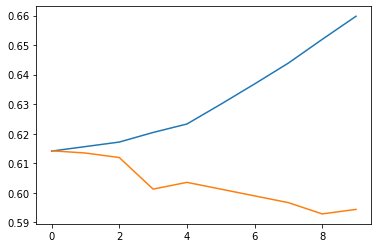

In [33]:
plt.plot(train_scores)
plt.plot(test_scores)
print(train_scores)
print(test_scores)

In [34]:
print(DecisionTreeClassifier(max_depth=3).fit(X_train,y_train).predict(X_test))
a = baseline_logit.predict(X_test)
np.mean(a)

1 - np.mean(tweets_to_split.stock_up)

[0 0 0 ... 0 0 0]


0.6141262803852622

---

In [2]:
nlp = sp.load('en_core_web_md') 

In [4]:

doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple is looking at buying U.K. startup for $1 billion
Apple PROPN nsubj
is AUX aux
looking VERB ROOT
at ADP prep
buying VERB pcomp
U.K. PROPN compound
startup NOUN dobj
for ADP prep
$ SYM quantmod
1 NUM compound
billion NUM pobj


In [5]:
token1, token2 = doc[0], doc[1] 
  
print("Similarity:", token1.similarity(token2))

Similarity: 0.19535309


In [7]:
doc[0]

Apple

In [18]:
c = nlp('red')
t = nlp('blue')

In [19]:
c.similarity(t)

0.8438410618229905

In [33]:
w1 = wordnet.synset('corn.n.01') # v here denotes the tag verb 
w2 = wordnet.synset('farmer.n.01') 
print(w1.wup_similarity(w2)) 

0.5454545454545454


In [59]:
tweets_stock_viable

,text,created_at,retweet_count,favorite_count,is_retweet,polarity,subjectivity,test,china,stock_dif,stock_up,tariff,farmer,trade,war
0,The debates especially the second and third pl...,2016-11-13 18:46:00,23410.0,113207.0,False,0.335714,0.429762,0.302381,0,-0.25,0,0,0,0,0
1,If the election were based on total popular vo...,2016-11-15 13:34:00,49623.0,179219.0,False,0.306667,0.696667,0.306667,0,-0.25,0,0,0,0,0
2,The Electoral College is actually genius in th...,2016-11-15 13:40:00,39125.0,128083.0,False,0.000000,0.400000,0.000000,0,-0.25,0,0,0,0,0
3,Very organized process taking place as I decid...,2016-11-16 02:55:00,27544.0,119611.0,False,0.143750,0.543750,0.143750,0,0.00,0,0,0,0,0
4,"I am not trying to get ""top level security cle...",2016-11-16 11:28:00,31102.0,99921.0,False,0.050000,0.550000,0.050000,0,0.25,1,0,0,0,0
5,The failing @nytimes story is so totally wrong...,2016-11-16 12:12:00,20825.0,77532.0,False,0.068750,0.506250,0.068750,0,0.75,1,0,0,0,0
6,I have recieved and taken calls from many fore...,2016-11-16 12:17:00,25694.0,88735.0,False,0.187500,0.312500,0.187500,1,-0.25,0,0,0,0,0
7,Australia New Zealand and more. I am always av...,2016-11-16 12:25:00,24112.0,90560.0,False,0.345455,0.451515,0.345455,0,0.25,1,0,0,0,0
8,My transition team which is working long hours...,2016-11-17 12:46:00,21195.0,96513.0,False,0.412500,0.637500,0.412500,0,-0.75,0,0,0,0,0
9,Just got a call from my friend Bill Ford Chair...,2016-11-18 02:01:00,49187.0,166484.0,False,0.000000,0.000000,0.000000,0,-0.50,0,0,0,0,0


In [1]:
doc = nlp(tweets_stock_viable['text'].values[1].lower())

print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)
    
c = nlp('china')
for token in doc:
    print(c.similarity(token))

NameError: name 'nlp' is not defined

In [46]:
tweets_stock_viable = pd.read_csv('data/tweets_stock_viable')

In [11]:
data = list(tweets_stock_viable['text'])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

//anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [31]:
for i in range(20):
    tweets_stock_viable['vec{}'.format(i)] = [0] * 6541

In [36]:


for i in range(6541):
    if i % 100 == 0:
        print(i)
    for j in range(20):
        tweets_stock_viable['vec{}'.format(j)][i] = model.docvecs[i][j]
    
tweets_stock_viable

0


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


KeyboardInterrupt: 

In [34]:
tweets_stock_viable = tweets_stock_viable.drop(columns=['vector'])

In [45]:
cols = ['vec{}'.format(i) for i in range(20)]
vectorized = pd.DataFrame(model.docvecs.doctag_syn0, columns=cols)
vectorized

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19
0,-7.729910,-1.626944,3.576761,2.191105,-5.905663,1.370421,-0.000984,-3.475857,2.488464,-2.511431,2.170762,1.129233,4.832506,7.447575,0.049152,-2.066307,3.287376,1.279340,0.510316,4.797930
1,-4.136260,-2.098870,3.750569,4.996654,-3.533436,5.037825,1.857743,-2.397212,-2.424084,-0.732563,2.525376,1.850704,6.794603,-1.851530,0.525502,2.013538,1.080770,-2.166932,-3.689578,-0.166067
2,0.600004,0.969946,4.983898,2.753030,-1.923276,2.260246,0.247173,-7.336071,-4.472570,2.370259,-1.501069,1.549322,4.034730,3.335521,3.111752,-5.002777,0.266859,3.771204,-1.718280,3.240672
3,-1.863677,-2.025139,4.502540,0.480184,-0.666162,1.373186,-0.089939,-3.406611,-2.213336,4.241301,-2.843509,-4.072886,3.123375,2.893671,-3.426319,2.022225,3.244137,4.381528,0.946370,-1.494560
4,2.814457,2.097140,2.920275,-0.483836,0.989237,2.301615,2.021865,-2.968311,1.244345,4.811765,-2.208260,-2.496633,1.563157,-4.321462,3.017375,-1.607728,4.111870,-6.167467,-1.889157,-2.857561
5,6.355107,-5.175958,1.253463,1.615526,3.175173,5.905987,-1.773138,-2.342774,1.447907,9.930144,1.396586,-3.309947,0.230492,-1.043554,-3.428851,1.294255,1.261909,4.373112,4.366190,0.699304
6,3.019368,-4.471625,-1.872121,1.302162,2.041248,2.836504,-1.196695,-6.618788,0.447361,8.533360,-2.550116,-3.738252,0.511399,0.473589,-1.025020,2.400804,4.303859,1.855765,1.874766,4.490651
7,6.083182,-1.122039,4.204681,2.069829,9.357327,1.271109,-0.106117,-6.180606,-1.159410,2.055234,0.785090,0.340071,-1.998360,-0.664536,-2.539206,3.033961,2.000247,-4.858373,-3.450068,9.191087
8,-4.341320,-0.746709,4.614961,3.026387,0.637754,7.870789,-4.890769,0.424828,3.686966,6.211490,5.642012,-1.573197,-0.096530,-1.932451,0.472644,5.069066,6.924801,-0.895455,-1.101331,-3.569235
9,1.993980,-5.783964,2.916360,-0.594394,-7.483468,2.130298,-0.501856,-0.546542,4.281534,2.247502,2.092900,-4.190371,1.862786,-3.587043,-0.944732,0.608500,-2.139659,-6.680800,1.948137,-4.818040


In [47]:
new_tweets = pd.concat([tweets_stock_viable, vectorized], axis=1)

In [48]:
new_tweets

,text,created_at,retweet_count,favorite_count,is_retweet,polarity,subjectivity,test,china,stock_dif,...,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19
0,The debates especially the second and third pl...,2016-11-13 18:46:00,23410.0,113207.0,False,0.335714,0.429762,0.302381,0,-0.25,...,2.170762,1.129233,4.832506,7.447575,0.049152,-2.066307,3.287376,1.279340,0.510316,4.797930
1,If the election were based on total popular vo...,2016-11-15 13:34:00,49623.0,179219.0,False,0.306667,0.696667,0.306667,0,-0.25,...,2.525376,1.850704,6.794603,-1.851530,0.525502,2.013538,1.080770,-2.166932,-3.689578,-0.166067
2,The Electoral College is actually genius in th...,2016-11-15 13:40:00,39125.0,128083.0,False,0.000000,0.400000,0.000000,0,-0.25,...,-1.501069,1.549322,4.034730,3.335521,3.111752,-5.002777,0.266859,3.771204,-1.718280,3.240672
3,Very organized process taking place as I decid...,2016-11-16 02:55:00,27544.0,119611.0,False,0.143750,0.543750,0.143750,0,0.00,...,-2.843509,-4.072886,3.123375,2.893671,-3.426319,2.022225,3.244137,4.381528,0.946370,-1.494560
4,"I am not trying to get ""top level security cle...",2016-11-16 11:28:00,31102.0,99921.0,False,0.050000,0.550000,0.050000,0,0.25,...,-2.208260,-2.496633,1.563157,-4.321462,3.017375,-1.607728,4.111870,-6.167467,-1.889157,-2.857561
5,The failing @nytimes story is so totally wrong...,2016-11-16 12:12:00,20825.0,77532.0,False,0.068750,0.506250,0.068750,0,0.75,...,1.396586,-3.309947,0.230492,-1.043554,-3.428851,1.294255,1.261909,4.373112,4.366190,0.699304
6,I have recieved and taken calls from many fore...,2016-11-16 12:17:00,25694.0,88735.0,False,0.187500,0.312500,0.187500,1,-0.25,...,-2.550116,-3.738252,0.511399,0.473589,-1.025020,2.400804,4.303859,1.855765,1.874766,4.490651
7,Australia New Zealand and more. I am always av...,2016-11-16 12:25:00,24112.0,90560.0,False,0.345455,0.451515,0.345455,0,0.25,...,0.785090,0.340071,-1.998360,-0.664536,-2.539206,3.033961,2.000247,-4.858373,-3.450068,9.191087
8,My transition team which is working long hours...,2016-11-17 12:46:00,21195.0,96513.0,False,0.412500,0.637500,0.412500,0,-0.75,...,5.642012,-1.573197,-0.096530,-1.932451,0.472644,5.069066,6.924801,-0.895455,-1.101331,-3.569235
9,Just got a call from my friend Bill Ford Chair...,2016-11-18 02:01:00,49187.0,166484.0,False,0.000000,0.000000,0.000000,0,-0.50,...,2.092900,-4.190371,1.862786,-3.587043,-0.944732,0.608500,-2.139659,-6.680800,1.948137,-4.818040


In [84]:
tweets_to_split = tweets_stock_viable.drop(columns=['stock_dif','text', 'is_retweet', 'created_at'])

X_train, X_test, y_train, y_test = train_test_split(tweets_to_split.loc[:, tweets_to_split.columns != 'stock_up'], 
                                                         tweets_to_split.stock_up, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = tweets_to_split.stock_up)

In [56]:
X_train

,retweet_count,favorite_count,polarity,subjectivity,test,china,tariff,farmer,trade,war,...,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19
920,14202.0,63653.0,0.866667,1.000000,0.800000,0,0,0,0,0,...,-1.978057,-2.288676,2.181712,5.795161,-1.802425,-0.913226,7.322484,3.851252,2.584102,-1.069940
268,34238.0,250940.0,0.800000,0.800000,0.800000,0,0,0,0,0,...,2.618648,4.633100,4.555906,-0.073978,-3.312904,1.784252,4.015709,-0.064089,1.488978,0.384193
4316,30708.0,107254.0,-0.146496,0.552652,-0.130871,0,0,0,0,0,...,-3.598776,1.322654,2.672334,-7.144516,1.586813,-0.329997,3.002136,-4.165592,3.326196,0.350396
6332,2556.0,9218.0,0.750000,1.000000,0.600000,0,0,0,0,0,...,-0.813777,3.599551,2.230967,0.254986,-4.212175,0.710693,-1.054833,-2.743149,4.450343,1.568891
3559,16456.0,73335.0,0.458667,0.566000,0.448667,1,0,0,0,1,...,-3.154233,-3.664471,5.889643,2.327403,-0.600586,2.663426,4.025499,1.737410,-3.377713,-3.070347
1991,9909.0,61655.0,0.875000,0.600000,0.700000,0,0,0,0,0,...,3.581841,-0.907313,2.442718,-0.170713,-6.300937,2.497867,5.863165,-0.228394,3.556810,-4.265709
1625,21002.0,89128.0,0.390000,0.750000,0.390000,0,0,0,0,0,...,1.329141,-3.387251,0.923542,-2.826308,-3.913676,-0.337836,-1.338545,-0.014342,-8.165625,2.520009
3907,26268.0,103218.0,-0.337500,0.450000,-0.275000,0,0,0,0,0,...,-5.376911,-2.109032,5.889731,3.762719,-1.062073,5.100274,-1.254469,-1.316323,0.802614,0.653616
6015,18158.0,81724.0,0.100000,0.466667,0.100000,0,0,0,0,0,...,-4.386224,0.859554,3.789902,2.764634,-2.250835,0.780374,-3.348697,-7.367869,-1.077247,3.286746
2236,18723.0,79525.0,-0.015000,0.480000,-0.040000,0,0,0,0,0,...,-1.544581,-3.012916,3.694568,-0.659029,-2.799913,-1.089294,-0.228582,-2.665502,-1.871803,3.021511


In [85]:
#logistic regression=
Logit = LogisticRegression(C = 100000)
baseline_logit = Logit.fit(X_train, y_train)

print('train score:', baseline_logit.score(X_train, y_train))
print('test score:', accuracy_score(baseline_logit.predict(X_test), y_test))

train score: 0.614105504587156
test score: 0.6134453781512605


//anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [86]:
X_train

,retweet_count,favorite_count,polarity,subjectivity,test,china_similarity,trade_similarity,tariff_similarity,war_similarity,xi_similarity,intellectual_similarity,property_similarity,farm_similarity,soy_similarity,fentanyl_similarity,fed_similarity
920,14202.0,63653.0,0.866667,1.000000,0.800000,0.356987,0.306019,0.565617,0.245278,0.620813,0.484221,0.498557,0.694810,0.252941,0.270580,0.345844
268,34238.0,250940.0,0.800000,0.800000,0.800000,0.348168,0.318167,0.571428,0.260079,0.637266,0.501071,0.515124,0.628478,0.167956,0.242586,0.348119
4316,30708.0,107254.0,-0.146496,0.552652,-0.130871,0.361364,0.322899,0.554089,0.248716,0.643892,0.494022,0.507588,0.702585,0.257812,0.279040,0.353508
6332,2556.0,9218.0,0.750000,1.000000,0.600000,0.269272,0.198348,0.105252,0.095189,0.419167,0.242959,0.267745,0.478290,0.223269,0.208434,0.204244
3559,16456.0,73335.0,0.458667,0.566000,0.448667,0.369634,0.320905,0.561861,0.281895,0.664134,0.515200,0.529660,0.696232,0.272020,0.298270,0.328966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6028,13074.0,54987.0,0.495833,0.597222,0.477778,0.337236,0.298883,0.546106,0.252729,0.618369,0.488126,0.502860,0.683114,0.171447,0.224327,0.333591
682,54056.0,154284.0,0.000000,0.100000,0.000000,0.367537,0.305342,0.578837,0.251361,0.613870,0.509041,0.525304,0.728392,0.161883,0.242035,0.373486
3548,12797.0,52172.0,0.568182,0.602273,0.468182,0.343051,0.303543,0.544075,0.272633,0.661294,0.509969,0.525226,0.689841,0.186780,0.247977,0.320322
693,12454.0,56016.0,0.000000,1.000000,0.000000,0.391982,0.349321,0.622977,0.257975,0.613708,0.520613,0.534395,0.715878,0.253097,0.289674,0.377060


In [57]:
# decision tree classifier
depths = [1,2,3,4,5,6,7,8,9,10]
train_scores, test_scores = [], []

for i in depths:
    tree = DecisionTreeClassifier(max_depth=i).fit(X_train,y_train)
    train_scores.append(accuracy_score(tree.predict(X_train), y_train))
    test_scores.append(accuracy_score(tree.predict(X_test), y_test))


[0.614105504587156, 0.6154434250764526, 0.6167813455657493, 0.6240443425076453, 0.6303516819571865, 0.6414373088685015, 0.6622706422018348, 0.6899847094801224, 0.7075688073394495, 0.7305045871559633]
[0.6142093200916731, 0.612681436210848, 0.6111535523300229, 0.6065699006875478, 0.6050420168067226, 0.6012223071046601, 0.5783040488922842, 0.573720397249809, 0.5760122230710466, 0.5485103132161956]


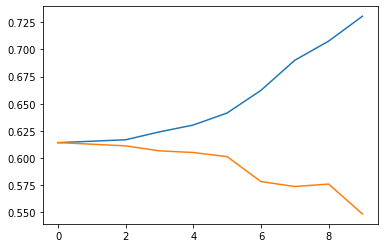

In [58]:
plt.plot(train_scores)
plt.plot(test_scores)
print(train_scores)
print(test_scores)

In [59]:



reference = [['china'], ['tariff']]
candidate = ['china', 'trade', 'war']
score = sentence_bleu(reference, candidate)
print(score)

1.384292958842266e-231


//anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
//anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
//anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

# START

In [2]:
tweets_stock_viable = pd.read_csv('data/tweets_stock_viable')

In [3]:
# https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = re.sub(r'http\S+', '', doc)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [5]:
from string import punctuation

remove_terms = punctuation + '0123456789'

tweets = [[word.lower() for word in sent.split() if word not in remove_terms] for sent in tweets_stock_viable['text']]
tweets = [' '.join(tok_sent) for tok_sent in tweets]
tweets = filter(None, normalize_corpus(tweets))
tweets = [tok_sent for tok_sent in tweets if len(tok_sent.split()) > 2]

tweets

['debates especially second third plus speeches intensity large rallies plus great supporters gave us win',
 'election based total popular vote would campaigned ny florida california even bigger easily',
 'electoral college actually genius brings states including smaller ones play campaigning much different',
 'organized process taking place decide cabinet many positions one knows finalists',
 'trying get top level security clearance children typically false news story',
 'failing nytimes story totally wrong transition going smoothly also spoken many foreign leaders',
 'recieved taken calls many foreign leaders despite failing nytimes said russia uk china saudi arabia japan',
 'australia new zealand always available nytimes upset looked like fools coverage',
 'transition team working long hours fantastic job seeing many great candidates today maga',
 'got call friend bill ford chairman ford advised keeping lincoln plant kentucky mexico',
 'worked hard bill ford keep lincoln plant kentu

In [6]:


tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(tweets)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in tweets]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 10655
Vocabulary Sample: [('great', 1), ('amp', 2), ('people', 3), ('president', 4), ('us', 5), ('country', 6), ('democrats', 7), ('news', 8), ('big', 9), ('fake', 10)]


In [7]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(us (5), large (290)) -> 1
(supporters (881), different (574)) -> 0
(plus (572), arrangements (7565)) -> 0
(second (436), nechama (9443)) -> 0
(great (1), win (46)) -> 1
(supporters (881), gave (423)) -> 1
(third (1147), losses (1716)) -> 0
(especially (465), second (436)) -> 1
(plus (572), plus (572)) -> 1
(plus (572), openings (3632)) -> 0


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 100)       1065500     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 100)       1065500     input_6[0][0]                    
____________________________________________________________________________________________

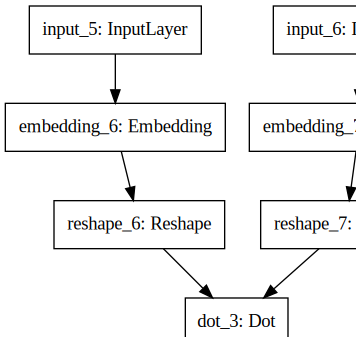

In [14]:
# https://stackoverflow.com/questions/52744467/keras-translation-from-sequential-to-functional-api
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input, Model

word_input = Input(shape=(1,))
word_x = layers.Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform')(word_input)
word_reshape = layers.Reshape((embed_size,))(word_x)

word_model = Model(word_input, word_reshape)    

context_input = Input(shape=(1,))
context_x = layers.Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform')(context_input)
context_reshape = layers.Reshape((embed_size,))(context_x)

context_model = Model(context_input, context_reshape)

dot_output = layers.dot([word_reshape, context_reshape], axes=1, normalize=False)

model_output = layers.Dense(1, kernel_initializer='glorot_uniform',
                            activation='sigmoid')(dot_output)

model = Model([word_input, context_input], model_output)

model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

# visualize model structure
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs


KeyboardInterrupt: 

In [16]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in tweets]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['china', 'tariff', 'democrat', 'farmer', 'trade', 'war', 'xi','president']}
similar_words

{'china': ['product', 'tariffs', 'buying', 'humanely', 'agricultural'],
 'tariff': ['tariffs', 'davidson', 'euro', 'struggled', 'reciprocate'],
 'democrat': ['party', 'bone', 'nancy', 'jexodus', 'foul'],
 'farmer': ['fatally', 'whitewashing', 'flawed', 'tune', 'devalued'],
 'trade': ['fair', 'barriers', 'tariffs', 'eu', 'wto'],
 'war': ['vietnam', 'connecticut', 'twenty', 'peace', 'harbor'],
 'xi': ['jinping', 'madame', 'differences', 'liyuan', 'republic'],
 'president': ['donald', 'pro', 'whistle', 'quid', 'quo']}

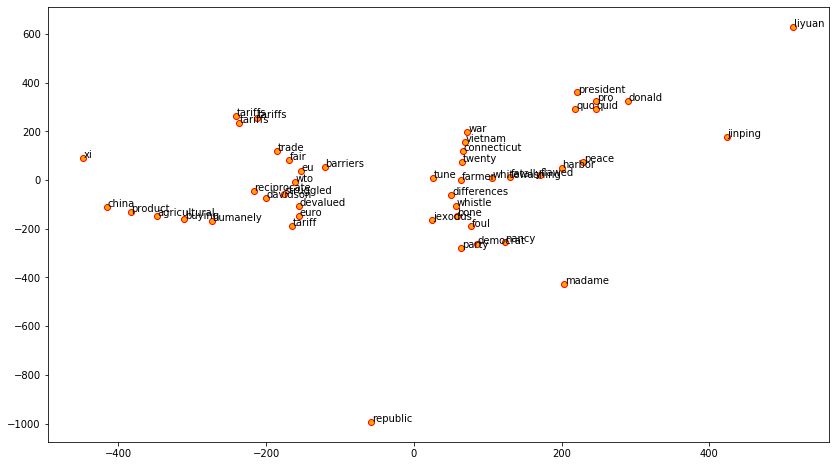

In [17]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [28]:
w2v_model.wv.n_similarity(['trade'], ['tariff'])

0.5444628

In [73]:
def add_similarity(word):
    succ = []
    for i in range(len(tweets_stock_viable)):
        similarities = []
        phrase = tweets_stock_viable['text'][i].lower()
        phrase = re.sub(r'[^a-zA-Z\s]', '', phrase, re.I|re.A)
        phrase = re.sub(r'http\S+', '', phrase)
        for w in phrase:
            if w in w2v_model.wv.vocab:
                similarities.append(w2v_model.wv.n_similarity([word], [w]))
        if similarities == []:
            succ.append(0)
        else:
            succ.append(max(similarities) + np.mean(similarities))
    tweets_stock_viable['{}_similarity'.format(word)] = succ
        

In [78]:
words = ['china', 'tariff', 'trade', 'war', 'xi', 'intellectual', 'property', 'farm', 'soy', 'fentanyl', 'fed']
for word in words:
    add_similarity(word)

In [81]:
tweets_stock_viable.columns
tweets_stock_viable = tweets_stock_viable.drop(columns=['china', 'tariff', 'farmer', 'trade', 'war'])
tweets_stock_viable.columns

Index(['text', 'created_at', 'retweet_count', 'favorite_count', 'is_retweet',
       'polarity', 'subjectivity', 'test', 'stock_dif', 'stock_up',
       'china_similarity', 'trade_similarity', 'tariff_similarity',
       'war_similarity', 'xi_similarity', 'intellectual_similarity',
       'property_similarity', 'farm_similarity', 'soy_similarity',
       'fentanyl_similarity', 'fed_similarity'],
      dtype='object')

In [93]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(max_depth = 6, n_estimators=55, max_features='sqrt').fit(X_train, y_train)
random_forest_train_score = accuracy_score(RFclassifier.predict(X_train), y_train)
random_forest_test_score = accuracy_score(RFclassifier.predict(X_test), y_test)
print('Random Forest Accuracy on Training Set:', random_forest_train_score)
print('Random Forest Accuracy on Test Set:', random_forest_test_score)

Random Forest Accuracy on Training Set: 0.6244266055045872
Random Forest Accuracy on Test Set: 0.6142093200916731
